## Imports

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import itertools
import math
from utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load data

In [2]:
foods = pd.read_csv('data/Food.csv', header=0, index_col=0)
compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
content = pd.read_csv('data/Content.csv', header=0, index_col=0)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_2696/3428497312.py:2: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_2696/3428497312.py:3: DtypeWarning: Columns (4,5,6,7,8,9,13,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  content = pd.read_csv('data/Content.csv', header=0, index_col=0)


## Processing the Data

In this task, I want to build a graph where each node is a compound. In this graph, an edge between compounds would indicate that they are found in the same food. Edges will be weighted by the number of foods that any two compounds share. Edges will also be coloured by the max count food type to indicate that a particular category of food most often shares these two compounds. The food type that colours the most edges can be thought of the food type that covers most compounds

## Compound Maps
For this first part, the goal will be to create compound graphs that act like a visual signature for each food item. We can denote the graph $G = (V, E)$. Each vertex $v \in V$ corresponds to a compound and the size of the node reflects the enrichment of that compound in the food of interest. $(u, v) \in E \iff$ these two compounds can be found in the same food item. The edge can be weighted according to the number of food items that share this compound.

### Parse Vertices

In [3]:
# Only keep relevant entries
content = content[content['source_type'] == 'Compound']
content = content[content['food_id'].isin(foods.index)]
content = content[content['source_id'].isin(compounds.index)]

# We just keep the observations that use the `mg/100g` unit for concentration measurement
content = content[content['orig_unit'].isin(['mg/100g', 'mg/100 g'])]
content.dropna(subset=['orig_content'], inplace=True)

# Only keep the compounds that are shared amongst the selected foods of interest
relevant_compounds = content['source_id'].unique()
compounds = compounds[compounds.index.isin(relevant_compounds)]

In [4]:
# Some compounds are observed many times in the same foods, so we take the mean observation concentration
mean_content = content.groupby(['food_id', 'source_id'])['orig_content'].mean()
mean_content = mean_content[mean_content > 0]

## Let's group the observations by food and obtain the observation count per food
#  This will help us choose the foods that have interesting compound maps to visualize
by_food = mean_content.groupby('food_id').count()
foods = foods.merge(by_food, left_index=True, right_index=True)
foods = foods.sort_values(by=['orig_content'], ascending=False)[['name', 'orig_content']]

In [5]:
foods

,name,orig_content
268,Beer,269
245,Carrot,211
57,Sweet orange,186
205,Corn,183
909,Green bell pepper,175
...,...,...
240,Japanese walnut,2
799,Cupuaçu,1
262,Black radish,1
265,Sweet rowanberry,1


In [6]:
# Now let's add the mean concentration for each food-compound pair to the compounds dataframe
pivoted = mean_content.reset_index().pivot(index='source_id', columns='food_id', values='orig_content')
pivoted.describe()

food_id,1,2,3,4,5,6,7,8,9,10,...,943,949,957,971,985,1019,1021,1022,1023,1024
count,2.000000,51.000000,2.000000,85.000000,76.000000,113.000000,57.000000,102.000000,60.000000,9.000000,...,93.000000,83.000000,101.000000,3.000000,31.000000,77.000000,105.000000,8.000000,44.000000,20.000000
mean,34.271429,69.304559,0.850000,270.216745,158.229251,403.272426,103.702642,156.319132,272.663150,17.334481,...,1176.356466,49.064940,549.752282,14.216667,628.035977,1317.440286,516.278370,46805.187500,1496.546748,2838.641360
std,10.263150,112.206663,0.494975,1145.042734,622.389149,1938.728383,206.933699,364.950641,487.075294,13.903768,...,6044.504631,198.358408,2298.010186,10.315068,1831.735059,5772.656944,2253.452070,113700.037034,8618.448284,12372.622588
min,27.014286,0.002100,0.500000,0.000785,0.000005,0.000050,0.000558,0.000045,0.002200,2.599615,...,0.010000,0.004000,0.000025,5.790000,0.002500,0.000038,0.000017,96.000000,0.003000,0.002200
25%,30.642857,0.255000,0.675000,0.039000,0.205864,0.090000,0.290000,0.003337,0.997125,4.520714,...,1.260000,0.200000,0.750000,8.465000,6.500000,0.379500,0.606667,791.000000,0.321125,0.360500
50%,34.271429,20.000000,0.850000,1.250000,9.732143,1.619759,30.000000,0.540692,40.650000,11.650357,...,8.000000,1.990000,6.255556,11.140000,95.000000,10.173913,5.000000,8140.000000,78.000000,3.776500
75%,37.900000,93.000000,1.025000,51.500000,72.019231,72.125000,100.000000,119.750000,385.037500,29.137500,...,100.000000,12.125000,110.000000,18.430000,181.500000,352.500000,110.000000,14150.000000,251.375000,88.000000
max,41.528572,450.000000,1.200000,8890.000000,5201.666667,13030.000000,1300.000000,1850.000000,2500.000000,39.400002,...,43593.500000,1547.550000,16000.000000,25.720000,8138.000000,40200.000000,16000.000000,327827.500000,57330.000000,55400.000000


In [7]:
# We can now merge the pivoted frame with the original compound frame to obtain the nodes of our graph
compounds_aug = compounds.merge(pivoted, left_index=True, right_index=True, how="outer")

### Parse edges

In [8]:
## We said that every pair of compounds will share an edge (u, v, w) where w is the number of 
#  foods that contain both compounds. This method will tell us how often two compounds co-occur
edgelist = Counter()

for idx, df_g in tqdm(mean_content.groupby(level=[0])):
    conn_compounds = sorted(df_g.index.get_level_values(1))
    pairs = itertools.combinations(conn_compounds, 2)
    edgelist.update(pairs)

100%|███████████████████████████████████████| 828/828 [00:00<00:00, 1877.84it/s]


In [9]:
'We have %d nodes and %d edges' %  (len(compounds_aug), len(edgelist))

'We have 1863 nodes and 226251 edges'

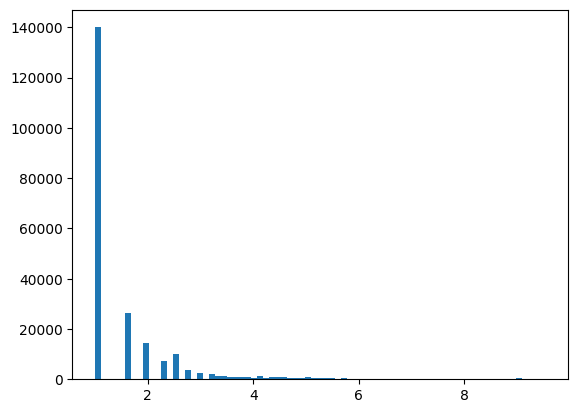

In [10]:
# Plot the histogram of edge weights (I take the log of weight values + 1 for normalization)
weights = np.log2(np.array(list(edgelist.values()))+1)
plt.hist(weights, bins=75)
plt.show()

### Build the graph!

In [16]:
g_nodes = compounds_aug.to_dict('index')
g_nodes = [(k, v) for k, v in g_nodes.items()]

g_edges = [(k[0], k[1], {'weight': w}) for k,w in edgelist.items()]

g = nx.Graph()

g.add_nodes_from(g_nodes)
g.add_edges_from(g_edges)

print(len(g.nodes))
print(len(g.edges))

1863
226251


In [17]:
# Save graph for further visualization with gephi
nx.write_gexf(g, "compound_maps.gexf")

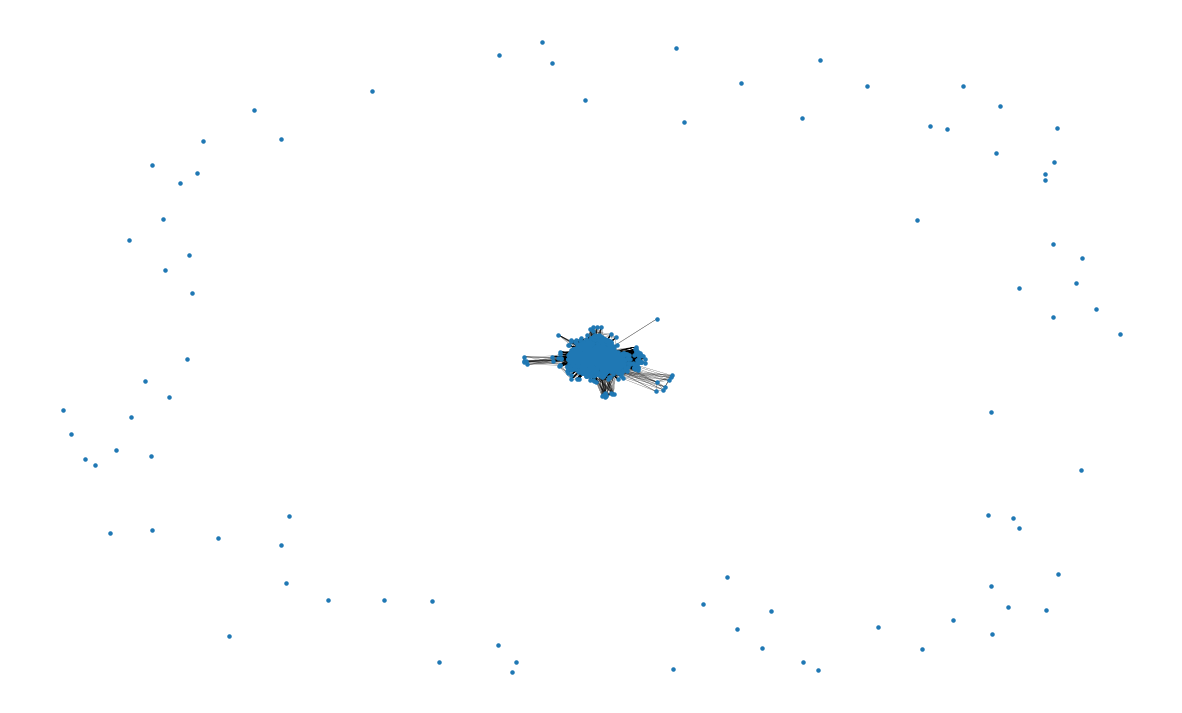

In [203]:
# Quick visualization
plot_options = {"node_size": 5, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(g, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(g, pos=pos, ax=ax, **plot_options)